# 0.0. IMPORTS

In [184]:
import sys
import psycopg2
import warnings

import pandas     as pd
import numpy      as np
import seaborn    as sns
import scikitplot as skplt
import xgboost    as xgb
import lightgbm   as lgb


from IPython.core.display    import HTML
from sklearn.model_selection import StratifiedKFold

from matplotlib              import pyplot          as plt
from sklearn                 import preprocessing   as pp
from sklearn                 import model_selection as ms
from sklearn                 import ensemble        as en
from sklearn                 import neighbors       as nh
from sklearn                 import linear_model    as lm

In [179]:
warnings.filterwarnings("ignore")

## 0.1. Aux Functions

In [249]:
# jupyter design
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 24

#     display(HTML('<style>.container { width:100% !important; }</style>'))
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.options.display.float_format = '{:,.4f}'.format
#     pd.set_option('display.expand_frame_repr', False)
#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

# prepare dataset for function precision and recall at k
def concat_order_data( x, y, yhat ):
    
    # copy data
    data = x.copy()
    data['response'] = y.copy()

    # propensity score
    data['score'] = yhat[:, 1].tolist()

    # sorted clients by propensity score
    data = data.sort_values( 'score', ascending=False )
    
    return data

# precision at k
def precision_at_k( data, k=20000 ):

    # reset index
    data = data.reset_index( drop = True )

    # ranking order columns
    data['ranking'] = data.index + 1

    # precision top k
    data['precision_top_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_top_k']

# recall at k
def recall_at_k( data, k=20000 ):

    # reset index
    data = data.reset_index( drop = True )

    # ranking order columns
    data['ranking'] = data.index + 1

    # precision top k
    data['recall_top_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_top_k']

# all at k metrics as dataframe
def at_k_metrics( model_name, x, y, yhat, k=20000 ):
    data = concat_order_data( x, y, yhat )
    
    pr = precision_at_k( data, k )
    re = recall_at_k( data, k )
    
    return pd.DataFrame({"Precision_at_k": "{}".format(np.round(pr,3)),
                         "Recall_at_k": "{}".format(np.round(re,3))}, index=[model_name])


# stratified cross validation
def cross_validation(model_name, model, x, y, k=20000 ):
    
    precision_at_k_list = []
    recall_at_k_list = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(x, y):
        
        x_train_cv = x.iloc[train_index]
        y_train_cv = y.iloc[train_index]
        
        x_test_cv = x.iloc[test_index]
        y_test_cv = y.iloc[test_index]
        
        # model training
        model.fit(x_train_cv, y_train_cv)
        
        # prediction
        pred = model.predict_proba(x_test_cv)
        
        # concat
        data = x_test_cv.copy()
        data['response'] = y_test_cv.copy()
        
        data['score'] = pred[:, 1].tolist()
        
        data = data.sort_values( 'score', ascending=False )
        
        # measuring at k metrics
        precision_at_k_list.append( precision_at_k( data, k ) )
        recall_at_k_list.append(recall_at_k( data, k ) )
        
    
    precision_at_k_mean, precision_at_k_std = np.round( np.mean( precision_at_k_list ), 2 ), np.round( np.std( precision_at_k_list ), 2 )
    recall_at_k_mean, recall_at_k_std = np.round( np.mean( recall_at_k_list ), 2 ), np.round( np.std( recall_at_k_list ), 2 )
   
    
    return pd.DataFrame({"Precision_at_k": "{} +/- {}".format(precision_at_k_mean, precision_at_k_std),
                         "Recall_at_k": "{} +/- {}".format(recall_at_k_mean, recall_at_k_std)}, index=[model_name])

Populating the interactive namespace from numpy and matplotlib


## 0.2. Data collection **CREDENCIAIS COMUNIDADE DS**

In [53]:
# connection = psycopg2.connect( user = 'member',
#                                password = 'cdspa',
#                                host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com',
#                                port = '5432',
#                                database = 'comunidadedsdb' )

# cursor = connection.cursor()

# query = """ SELECT *
#             FROM pa004.users
#             LEFT JOIN pa004.insurance on ( users.id = insurance.id )
#             LEFT JOIN pa004.vehicle on ( users.id = vehicle.id ) """

# cursor.execute( query )

# table = cursor.fetchall()

# outputquery = 'copy ({0}) to stdout with csv header'.format( query )

# with open( 'dataset.csv', 'w' ) as f:
#     cursor.copy_expert( outputquery, f )

# cursor.close()
# connection.close()

In [54]:
df_raw = pd.read_csv( 'data/train_dataset.csv' )
df_raw = df_raw.drop( df_raw.columns[[ 5, 10 ]], axis=1 )

# 1.0. DATA DESCRIPTION

In [55]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [56]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 381109
Number of columns: 12


## 1.2. Data types

In [57]:
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
dtype: object

## 1.3. NA check

In [58]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.4. Descriptive Statistics

In [59]:
df_num = df1.select_dtypes( include=[ 'int64'] )

### 1.4.1 Numerical attributes

In [60]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# central tendency - mean, median
ct1 = pd.DataFrame( df_num.apply( lambda x: np.mean( x ) ) ).T
ct2 = pd.DataFrame( df_num.apply( lambda x: np.median( x ) ) ).T

# dispersion metrics - min, max, range, std, skewness, kurtosis
dm1 = pd.DataFrame( df_num.apply( lambda x: np.min( x ) ) ).T
dm2 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) ) ).T
dm3 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) - np.min( x ) ) ).T
dm4 = pd.DataFrame( df_num.apply( lambda x: np.std( x ) ) ).T
dm5 = pd.DataFrame( df_num.apply( lambda x: x.skew() ) ).T
dm6 = pd.DataFrame( df_num.apply( lambda x: x.kurtosis() ) ).T

# concat
df_description = pd.concat( [ dm1, dm2, dm3, ct1, ct2, dm4, dm5, dm6 ] ).T
df_description.columns = ( 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis' )
df_description

,min,max,range,mean,median,std,skewness,kurtosis
id,1.000,381109.000,381108.000,190555.000,190555.000,110016.692,-0.000,-1.200
age,20.000,85.000,65.000,38.823,36.000,15.512,0.673,-0.566
region_code,0.000,52.000,52.000,26.389,28.000,13.230,-0.115,-0.868
policy_sales_channel,1.000,163.000,162.000,112.034,133.000,54.204,-0.900,-0.971
previously_insured,0.000,1.000,1.000,0.458,0.000,0.498,0.168,-1.972
annual_premium,2630.000,540165.000,537535.000,30564.390,31669.000,17213.132,1.766,34.005
vintage,10.000,299.000,289.000,154.347,154.000,83.671,0.003,-1.201
response,0.000,1.000,1.000,0.123,0.000,0.328,2.302,3.299
driving_license,0.000,1.000,1.000,0.998,1.000,0.046,-21.595,464.354


# 2.0. FEATURE ENGINEERING

In [61]:
df2 = df1.copy()

In [62]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'below_1_year' if x == '< 1 Year' else 
                                                         'between_1_2_years' if x == '1-2 Year' else 'over_2_years' )

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# 3.0. DATA FILTERING

In [63]:
df3 = df2.copy()

# 4.0. EXPLORATORY DATA ANALYSIS

In [64]:
df4 = df3.copy()

## 4.1. Univarieted analysis

### 4.1.1. gender

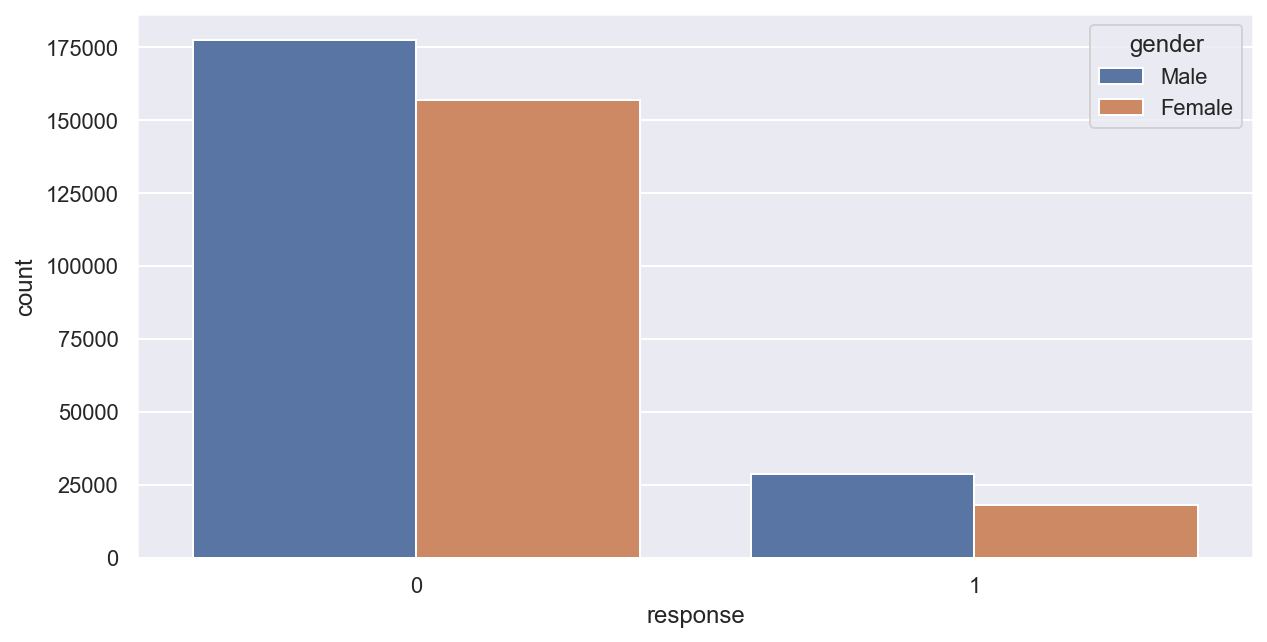

In [65]:
aux = df4[['gender','response']].value_counts().reset_index()
aux.columns = ['gender','response','count']
sns.barplot( x = 'response', y = 'count', hue = 'gender', data=aux );

### 4.1.2. age

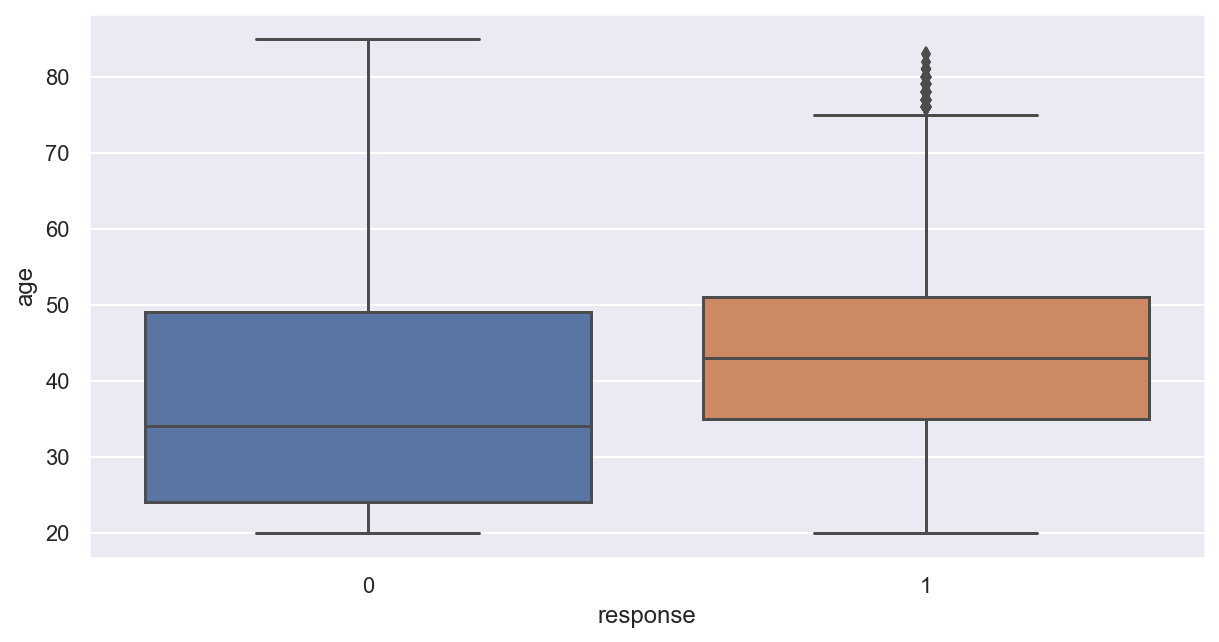

In [66]:
sns.boxplot( x = 'response', y = 'age', data=df4 );

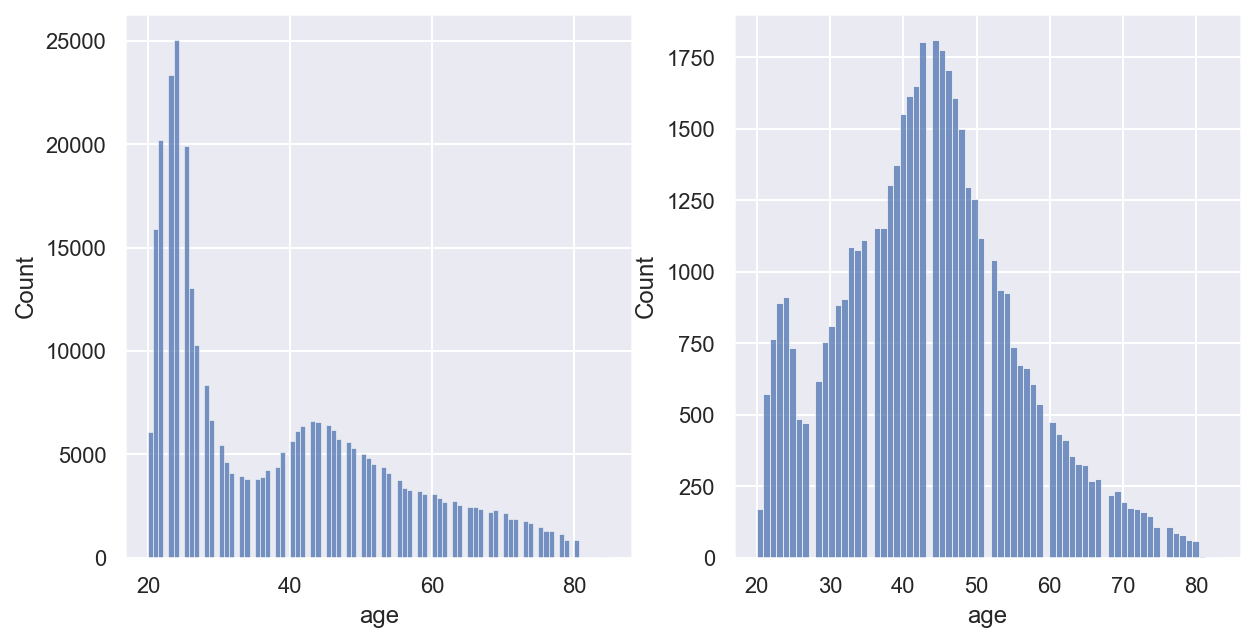

In [67]:
plt.subplot( 1, 2, 1 )
aux0 = df4.loc[ df4['response'] == 0, 'age' ]
sns.histplot( aux0 );

plt.subplot( 1, 2, 2 )
aux1 = df4.loc[ df4['response'] == 1, 'age' ]
sns.histplot( aux1 );

### 4.1.3. region code

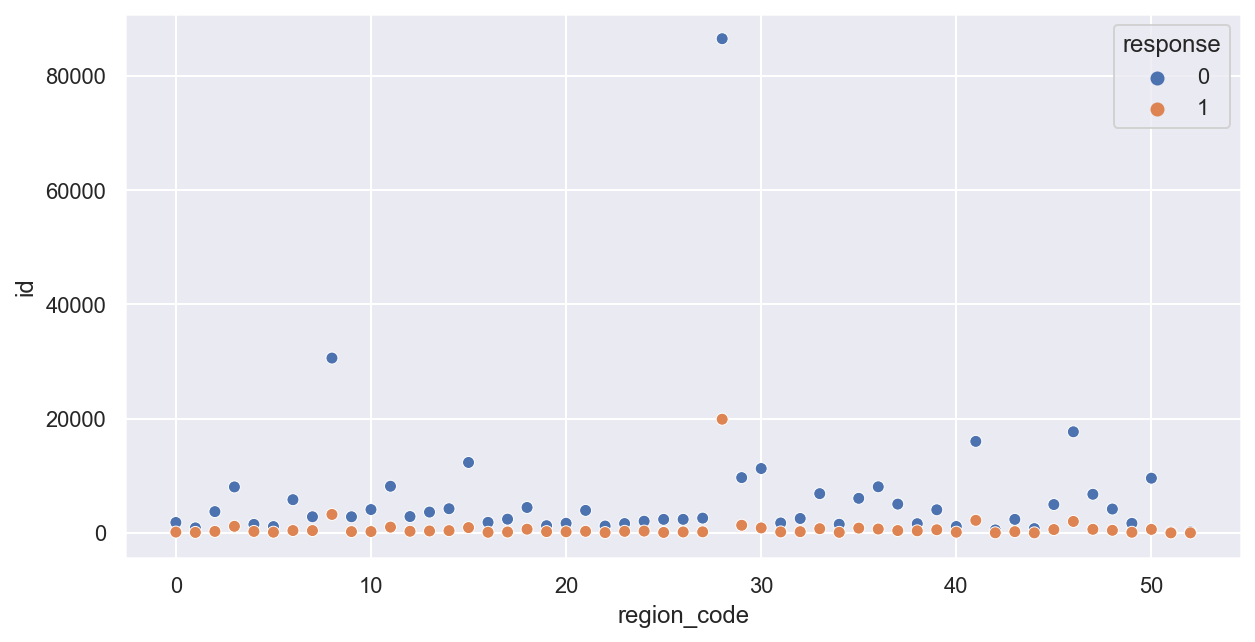

In [68]:
aux = df4[['id','region_code','response']].groupby( ['region_code','response'] ).count().reset_index()
sns.scatterplot( x = 'region_code', y='id', hue='response', data=aux );

### 4.1.4. policy sales channel

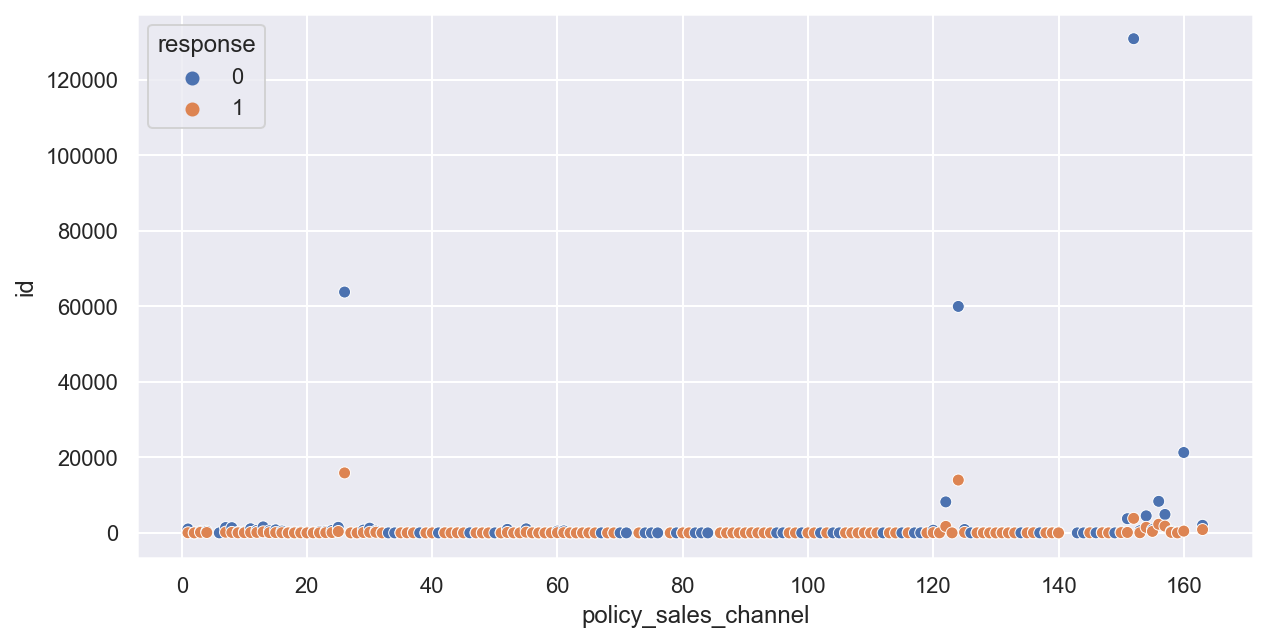

In [69]:
aux = df4[['id','policy_sales_channel','response']].groupby( ['policy_sales_channel','response'] ).count().reset_index()
sns.scatterplot( x='policy_sales_channel', y='id', hue='response', data=aux );

### 4.1.5. annual premium

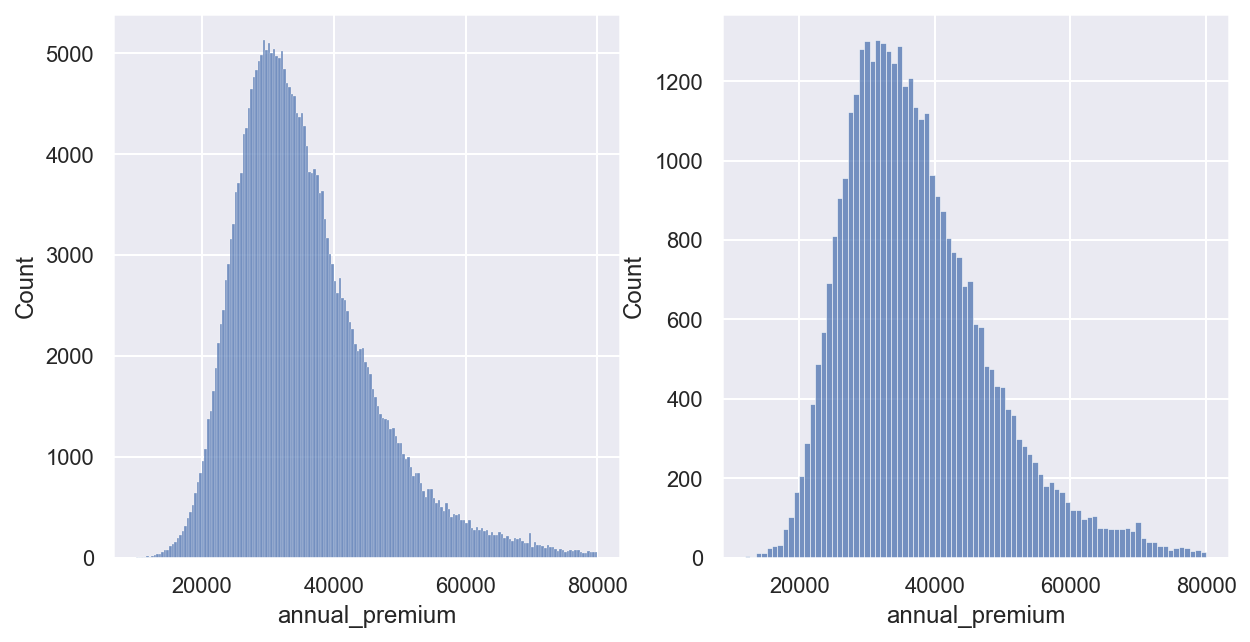

In [70]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

plt.subplot( 1, 2, 1 )
aux0 = aux.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux0 );

plt.subplot( 1, 2, 2 )
aux1 = aux.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux1 );

### 4.1.6. vintage

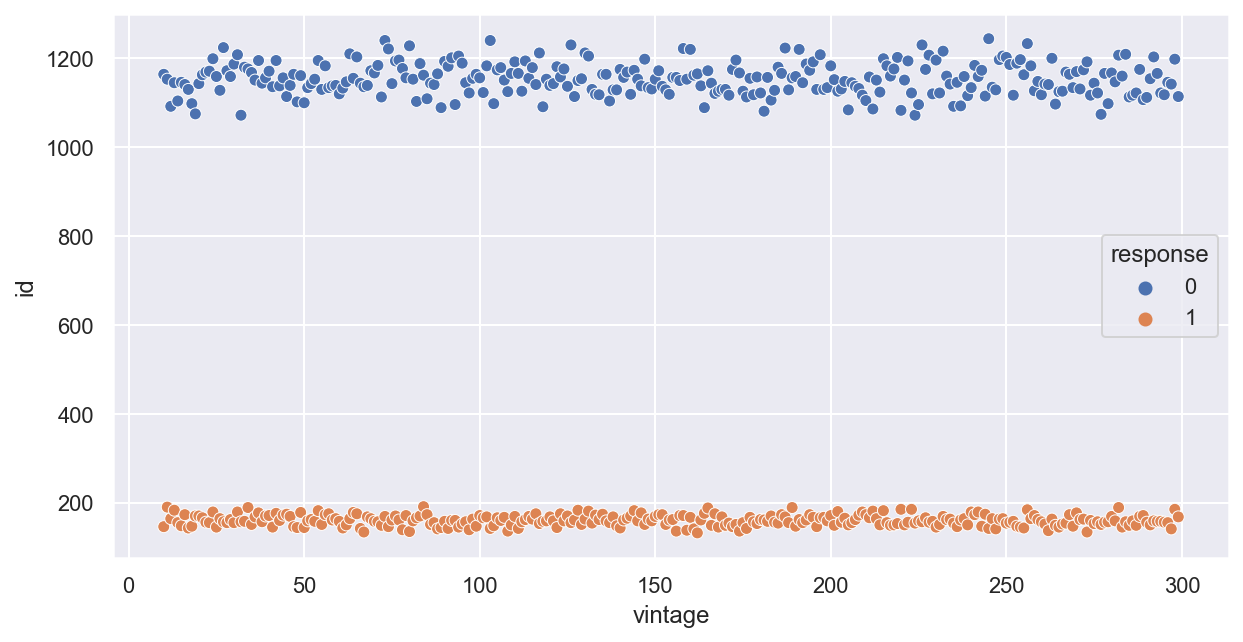

In [71]:
aux = df4[['id','vintage','response']].groupby(['vintage','response']).count().reset_index()
sns.scatterplot( x='vintage', y='id', hue='response', data=aux );

### 4.1.8. driving license

In [72]:
df4[['id','driving_license','response']].groupby(['driving_license','response']).count().reset_index()

,driving_license,response,id
0,0,0,771
1,0,1,41
2,1,0,333628
3,1,1,46669


### 4.1.9. vehicle age

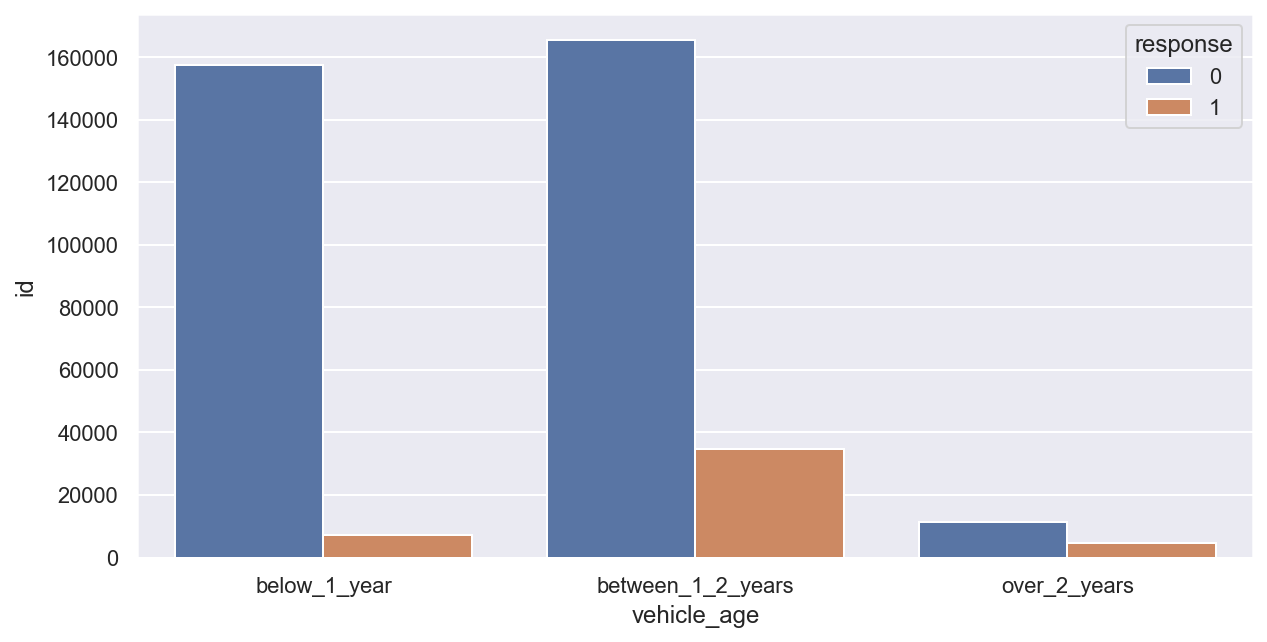

In [73]:
aux = df4[['id','vehicle_age','response']].groupby(['vehicle_age','response']).count().reset_index()
sns.barplot( x='vehicle_age', y='id', hue='response', data=aux );

### 4.1.10. vehicle damage

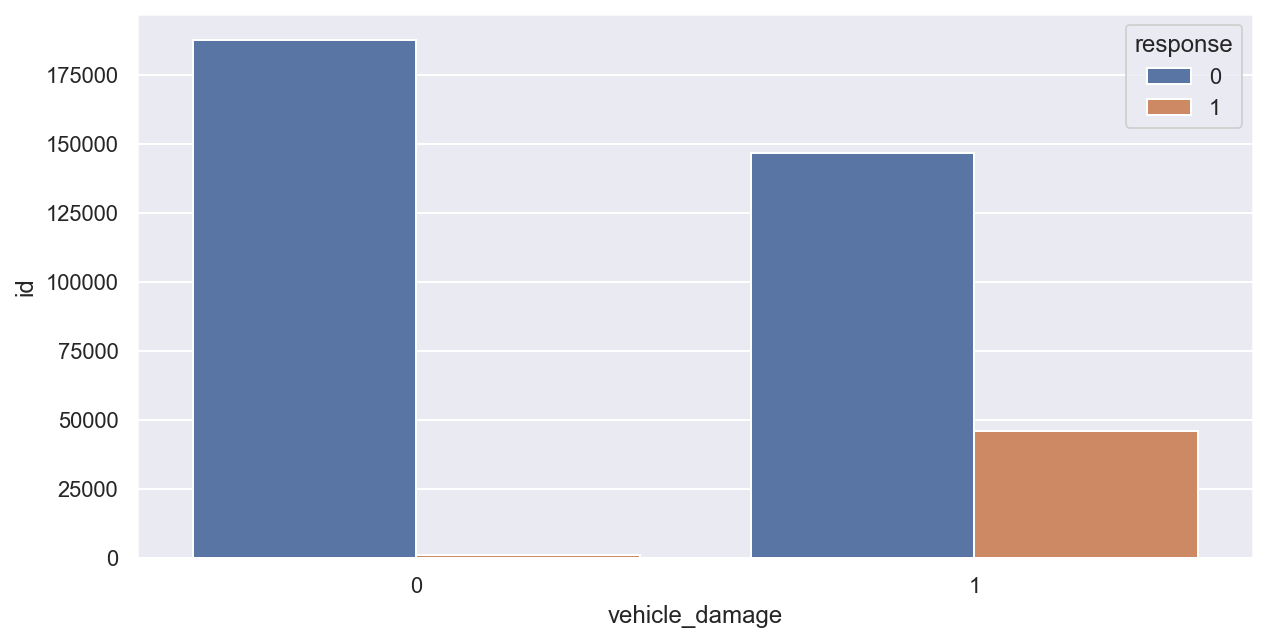

In [74]:
aux = df4[['id','vehicle_damage','response']].groupby( ['vehicle_damage','response'] ).count().reset_index()
sns.barplot( x='vehicle_damage', y='id', hue='response', data=aux );

## 4.2. Bivarieted analysis

**Hypothesis list:**

**H1**:

**H2**: 

**H3**:

**H4**:

**H5**:

**H6**:

**H7**:

**H8**:

**H9**:

**H10**:

## 4.3. Multivarieted analysis

In [75]:
num_attributes = df4.drop( ['id','gender','vehicle_age'], axis=1 )

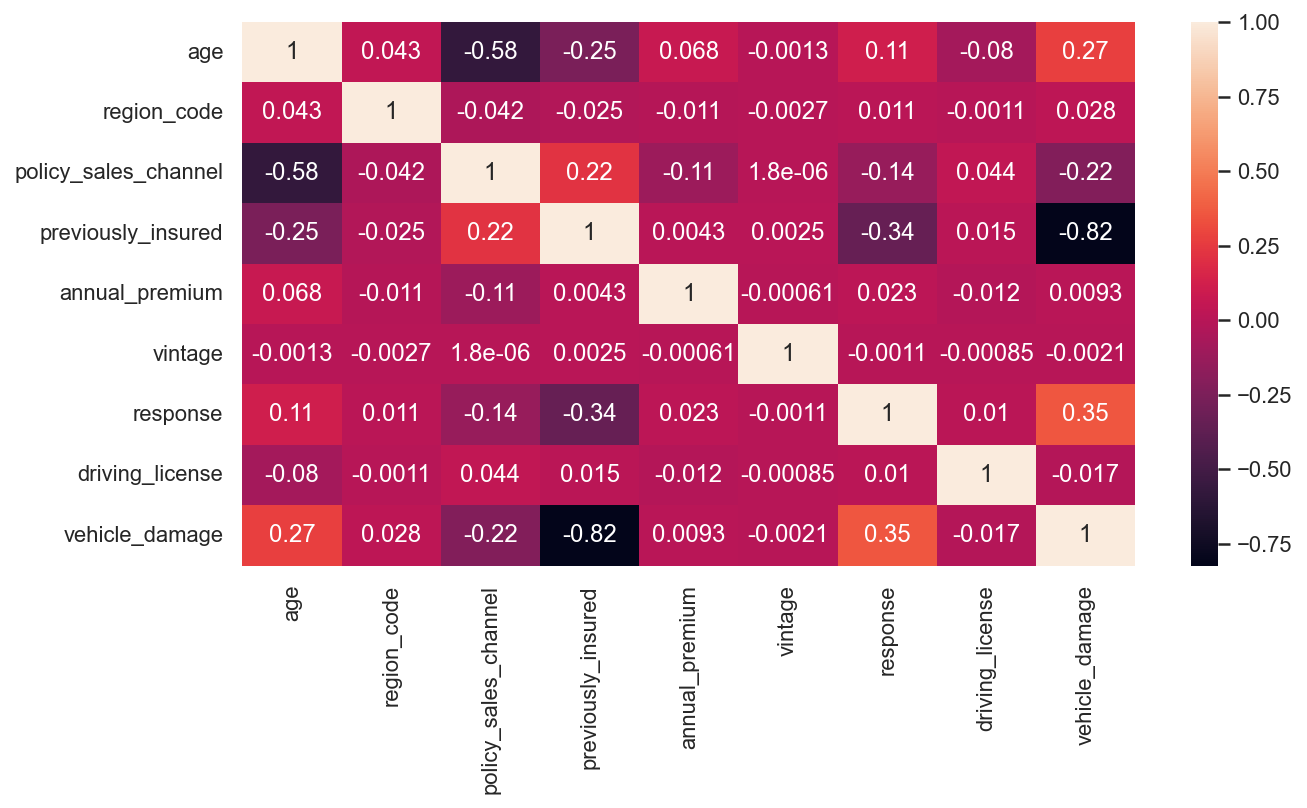

In [76]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 5.0. DATA PREPARATION

In [88]:
# Train and validation split

X_general = df4.drop( 'response', axis=1 )
Y_general = df4['response']

x_train, x_validation, y_train, y_validation = ms.train_test_split( X_general, Y_general, test_size=0.20 )

df5 = pd.concat( [ x_train, y_train ], axis=1 )

## 5.1. Normalization

In [89]:
# annual premium - normal curve

ss = pp.StandardScaler()
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2. Rescaling

In [90]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## 5.3. Encoding

In [91]:
# region code - Target Encoding
target_encoding_region_code = df5.groupby( 'region_code' )['response'].mean()
df5['region_code'] = df5['region_code'].map( target_encoding_region_code )

# policy sales channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5['policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

# gender
le = pp.LabelEncoder()
df5['gender'] = le.fit_transform( df5['gender'] )

# vehicle age - One Hot Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

## Validation Preparation

In [92]:
# annual premium - normal curve
x_validation['annual_premium'] = ss.fit_transform( x_validation[['annual_premium']].values )

# age
x_validation['age'] = mms_age.fit_transform( x_validation[['age']].values )

# vintage
x_validation['vintage'] = mms_vintage.fit_transform( x_validation[['vintage']].values )

# region code - Target Encoding
x_validation['region_code'] = x_validation['region_code'].map( target_encoding_region_code )

# policy sales channel - Frequency Encoding
x_validation['policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# gender
x_validation['gender'] = le.fit_transform( x_validation['gender'] )

# vehicle age - One Hot Encoding
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# fill na
x_validation = x_validation.fillna( 0 )

# 6.0. FEATURE SELECTION

In [82]:
# # model
# forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# # training
# x_train_fselection = df5.drop( ['id','response'], axis=1 )
# y_train_fselection = y_train.values
# forest.fit( x_train_fselection, y_train_fselection )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:

                         feature  importance
0                        vintage       0.273
0                 annual_premium       0.245
0                            age       0.166
0                    region_code       0.104
0                 vehicle_damage       0.068
0           policy_sales_channel       0.060
0             previously_insured       0.057
0       vehicle_age_below_1_year       0.014
0  vehicle_age_between_1_2_years       0.006
0                         gender       0.005
0       vehicle_age_over_2_years       0.002
0                driving_license       0.000


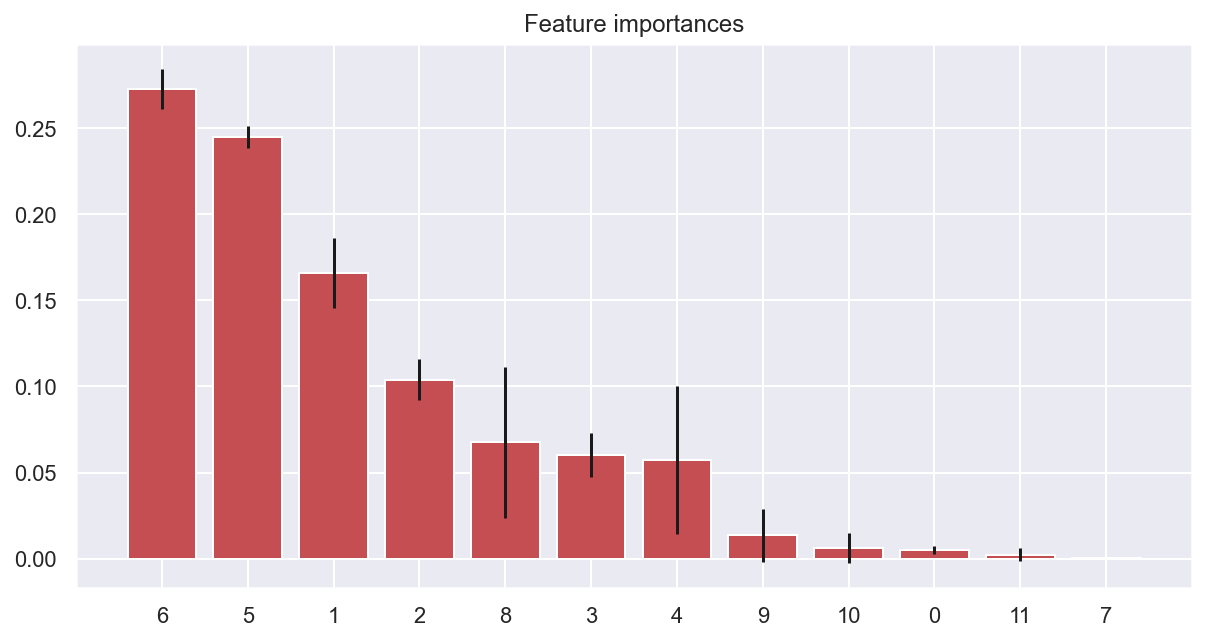

In [83]:
# importances = forest.feature_importances_
# std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
# indices = np.argsort( importances )[::-1]

# # print the feature ranking
# df = pd.DataFrame()

# print( 'Feature Ranking:\n' )
# for i, j in zip( x_train_fselection,forest.feature_importances_ ):
#     aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
#     df = pd.concat( [df, aux], axis=0 )
    
# print( df.sort_values( 'importance', ascending=False ) ) 

# # plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title( 'Feature importances' )
# plt.bar( range( x_train_fselection.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
# plt.xticks( range(x_train_fselection.shape[1]), indices )
# plt.xlim( [-1, x_train_fselection.shape[1]] )
# plt.show()

# 7.0. MACHINE LEARNING

In [255]:
selected_cols = [ 'vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                  'policy_sales_channel', 'previously_insured' ]

x_train = df5[ selected_cols ]
x_val = x_validation[ selected_cols ]
y_val = y_validation.copy()

## 7.1. KNN

In [256]:
# model
knn_model = nh.KNeighborsClassifier( n_neighbors=10 )

# model training
knn_model.fit( x_train, y_train )

# prediction
yhat_knn = knn_model.predict_proba( x_val )

### Precision and Recall at K metrics

In [257]:
knn_metrics = at_k_metrics( 'KNN', x_validation, y_validation, yhat_knn )
knn_metrics

,Precision_at_k,Recall_at_k
KNN,0.295,0.64


### Cumulative Gains and Lift curves

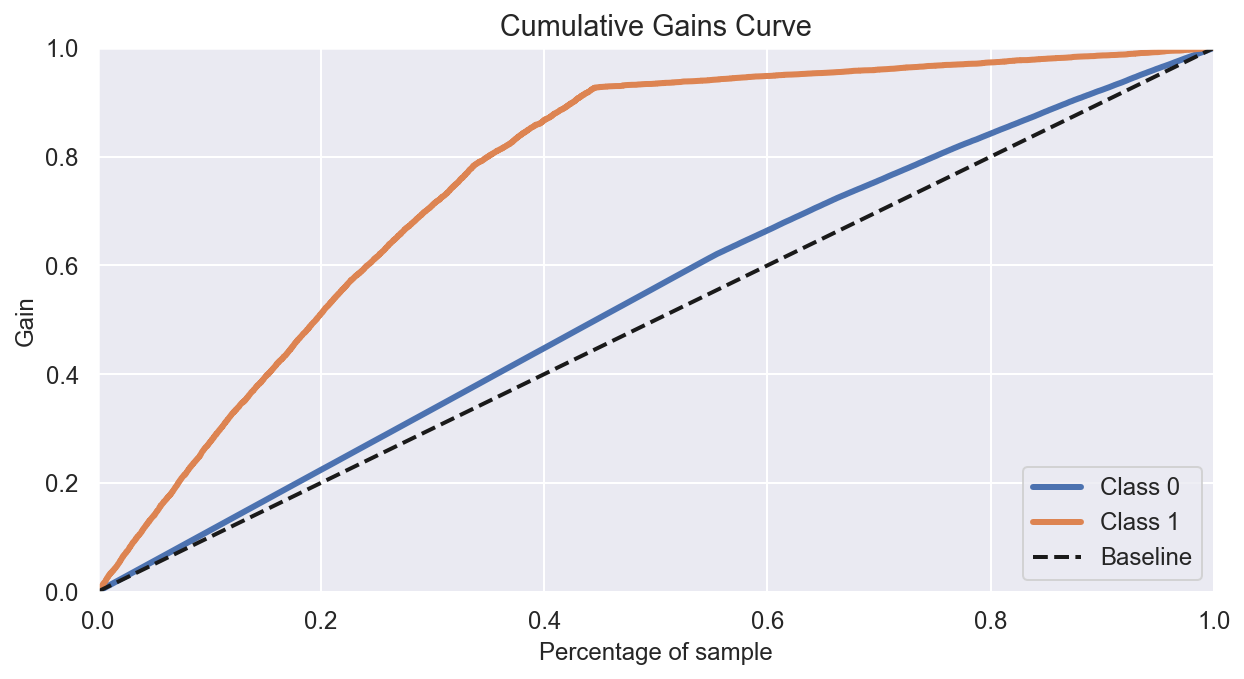

In [258]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

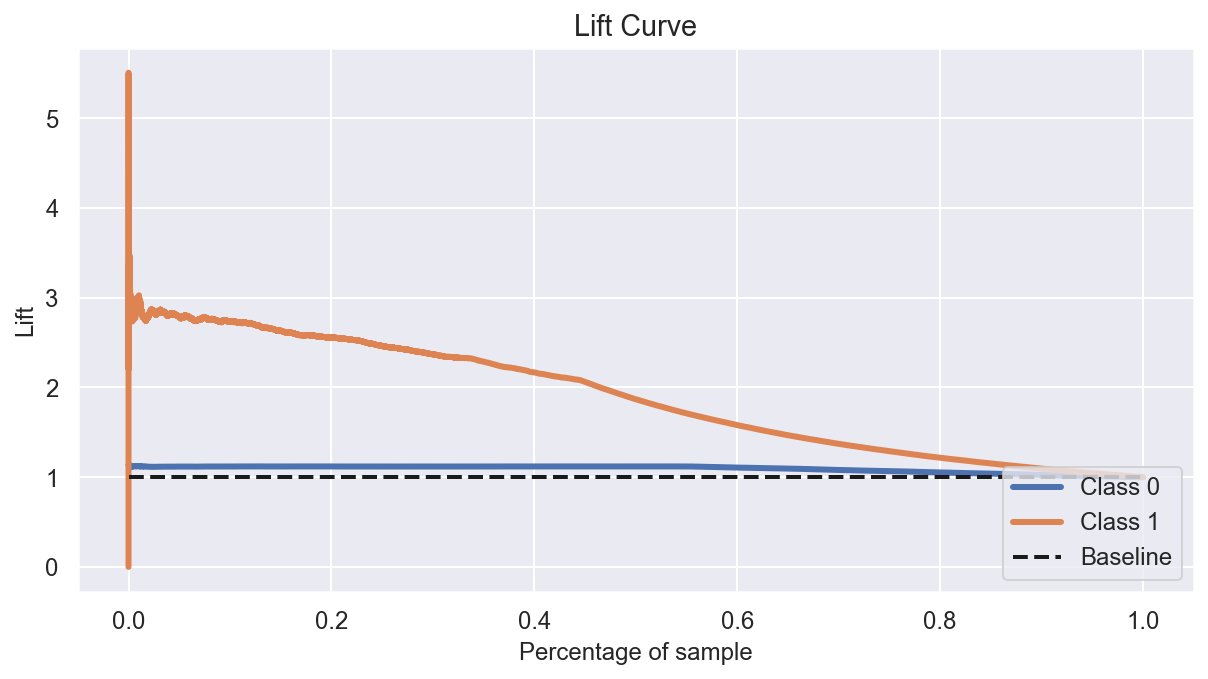

In [259]:
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

### Stratified Cross Validation

In [260]:
knn_cv = cross_validation( 'KNN', knn_model, x_train, y_train )
knn_cv

,Precision_at_k,Recall_at_k
KNN,0.28 +/- 0.0,0.76 +/- 0.0


## 7.2. Logistic Regression

In [261]:
# model
lr = lm.LogisticRegression( random_state=42 )

# model training
lr.fit( x_train, y_train )

# prediction
yhat_lr = lr.predict_proba( x_val )

### Precision and Recall at K metrics

In [262]:
lr_metrics = at_k_metrics( 'Logistic Regression', x_validation, y_validation, yhat_lr )
lr_metrics

,Precision_at_k,Recall_at_k
Logistic Regression,0.286,0.62


### Cumulative Gains and Lift curves

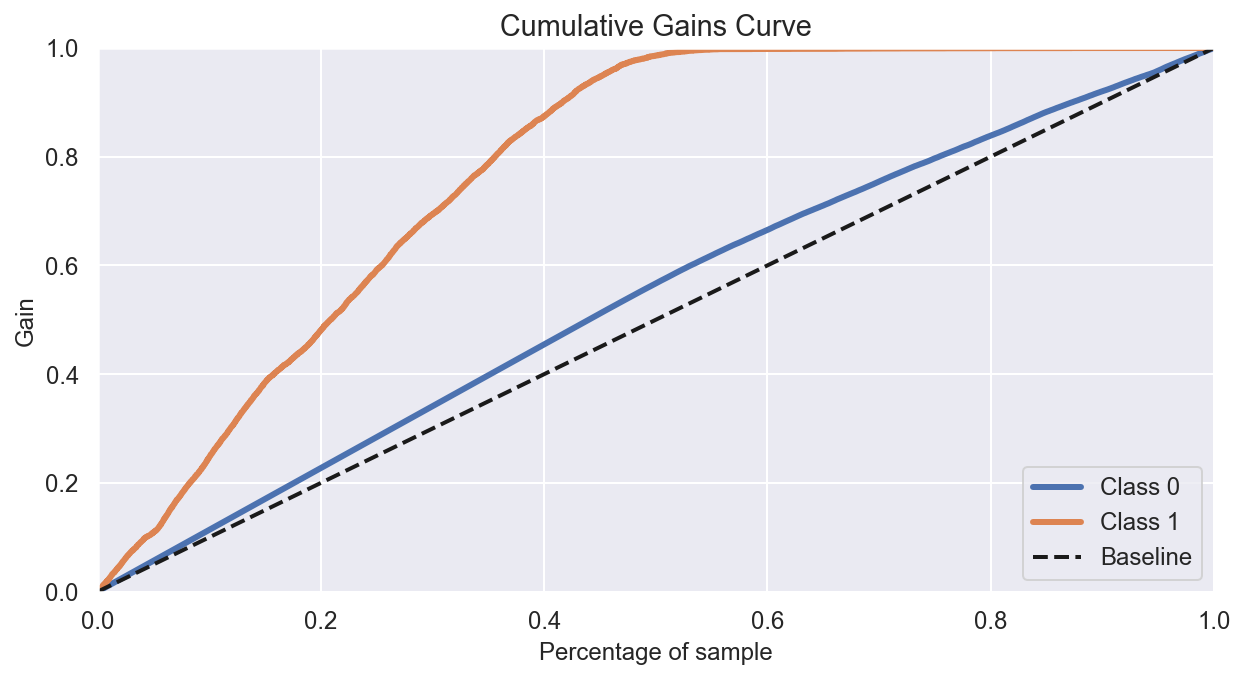

In [263]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

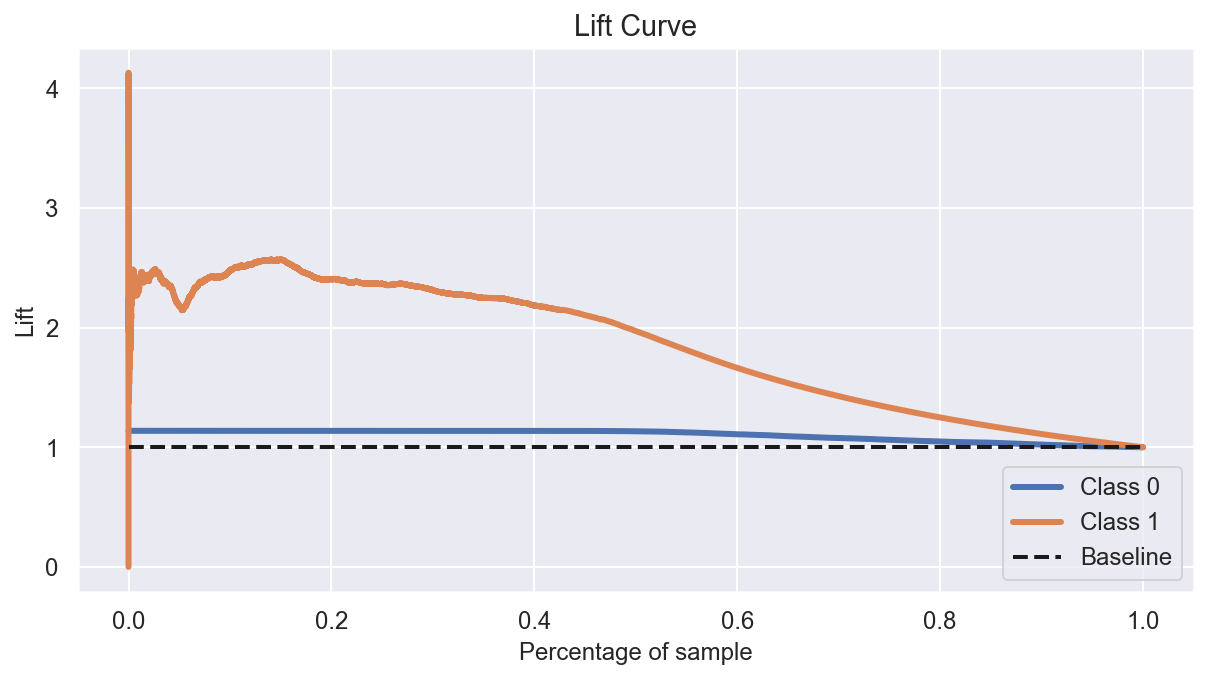

In [264]:
skplt.metrics.plot_lift_curve( y_val, yhat_lr);

### Stratified Cross Validation

In [265]:
lr_cv = cross_validation( 'Logistic Regression', lr, x_train, y_train )
lr_cv

,Precision_at_k,Recall_at_k
Logistic Regression,0.28 +/- 0.0,0.74 +/- 0.01


## 7.3. Extra Trees

In [266]:
# model
et = en.ExtraTreesClassifier( n_estimators=150, n_jobs=-1, random_state=42 )

# model training
et.fit( x_train, y_train )

# prediction
yhat_et = et.predict_proba( x_val )

### Precision and Recall at K metrics

In [267]:
et_metrics = at_k_metrics( 'Extra Trees',x_validation, y_validation, yhat_et )
et_metrics

,Precision_at_k,Recall_at_k
Extra Trees,0.299,0.649


### Cumulative Gains and Lift curves

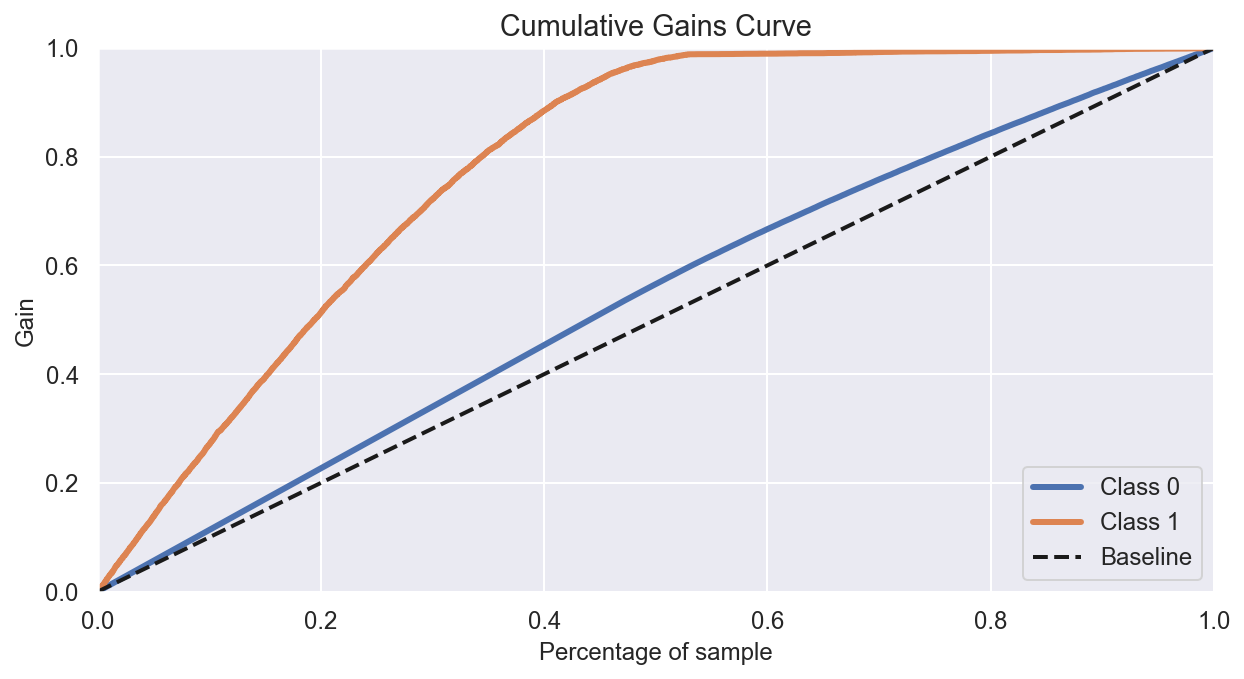

In [268]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

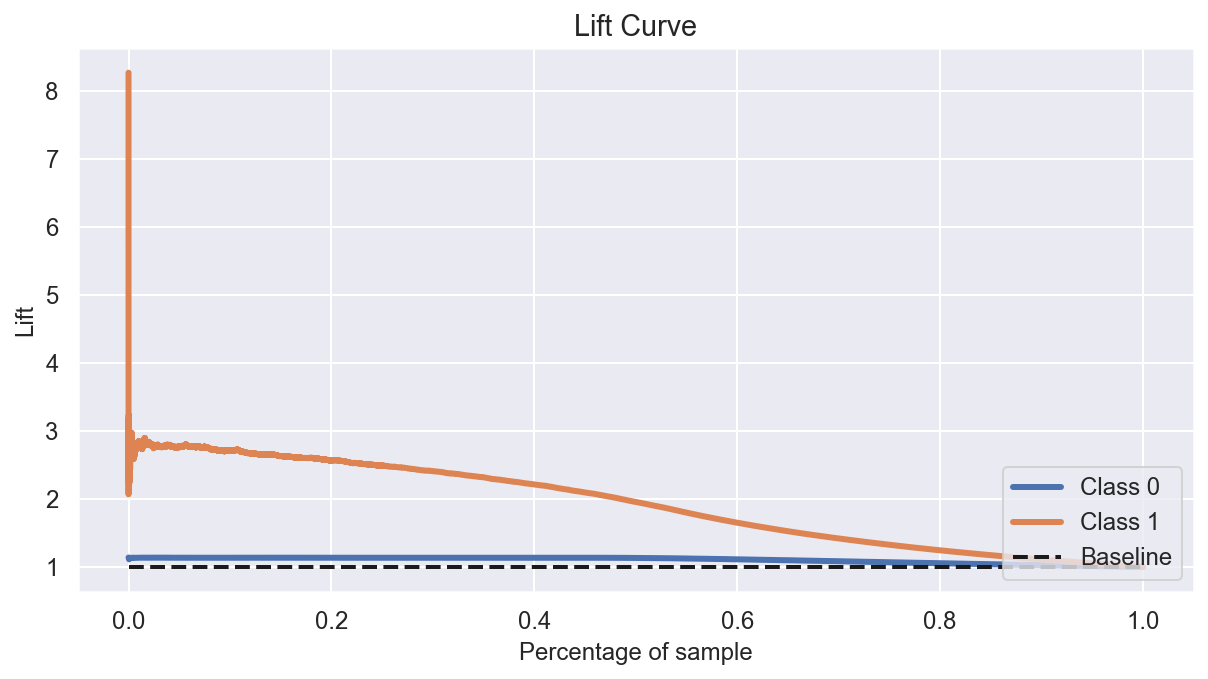

In [269]:
skplt.metrics.plot_lift_curve( y_val, yhat_et);

### Stratified Cross Validation

In [270]:
et_cv = cross_validation( 'Extra Trees', et, x_train, y_train )
et_cv

,Precision_at_k,Recall_at_k
Extra Trees,0.29 +/- 0.0,0.77 +/- 0.01


## 7.4. XGBoost 

In [271]:
# model
model_xgb = xgb.XGBClassifier(objective='binary:logistic', verbosity=0)

# training
model_xgb.fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict_proba( x_val )

### Precision and Recall at K metrics

In [272]:
model_xgb_metrics = at_k_metrics( 'XGBoost', x_validation, y_validation, yhat_xgb )
model_xgb_metrics

,Precision_at_k,Recall_at_k
XGBoost,0.329,0.714


### Cumulative Gains and Lift curves

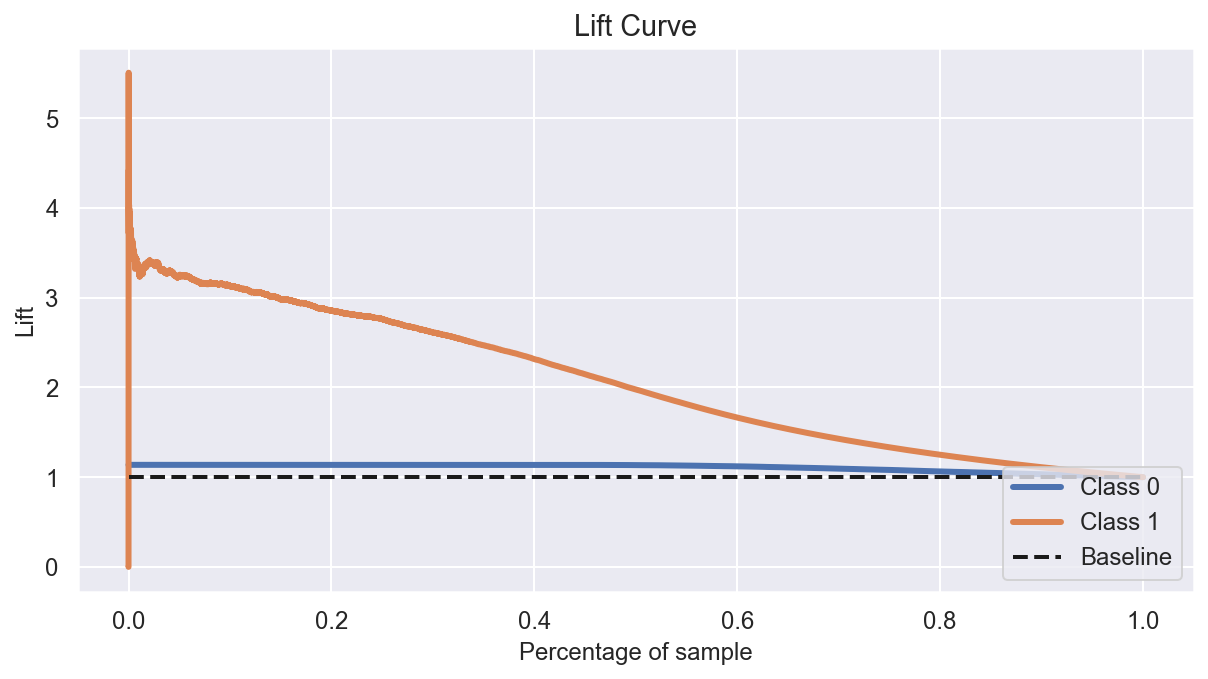

In [273]:
skplt.metrics.plot_lift_curve( y_val, yhat_xgb );

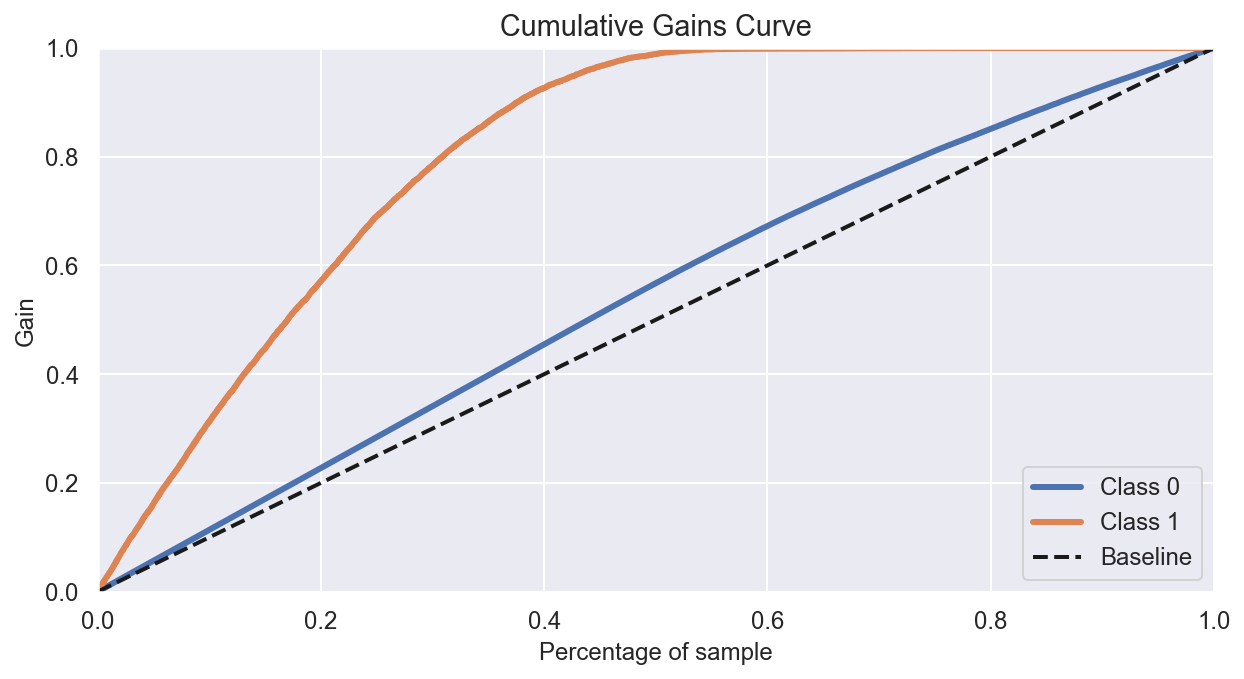

In [274]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb );

### Stratified Cross Validation

In [275]:
model_xgb_cv = cross_validation( 'XGBoost', model_xgb, x_train, y_train )
model_xgb_cv

,Precision_at_k,Recall_at_k
XGBoost,0.31 +/- 0.0,0.82 +/- 0.0


## 7.5. LightGBM

In [276]:
# model
model_lgb = lgb.LGBMClassifier(objective='binary', class_weight='balanced')

# training
model_lgb.fit( x_train, y_train )

# prediction
yhat_lgb = model_lgb.predict_proba( x_val )

### Precision and Recall at K metrics

In [277]:
model_lgb_metrics = at_k_metrics( 'LightGBM', x_validation, y_validation, yhat_lgb )
model_lgb_metrics

,Precision_at_k,Recall_at_k
LightGBM,0.331,0.719


### Cumulative Gains and Lift curves

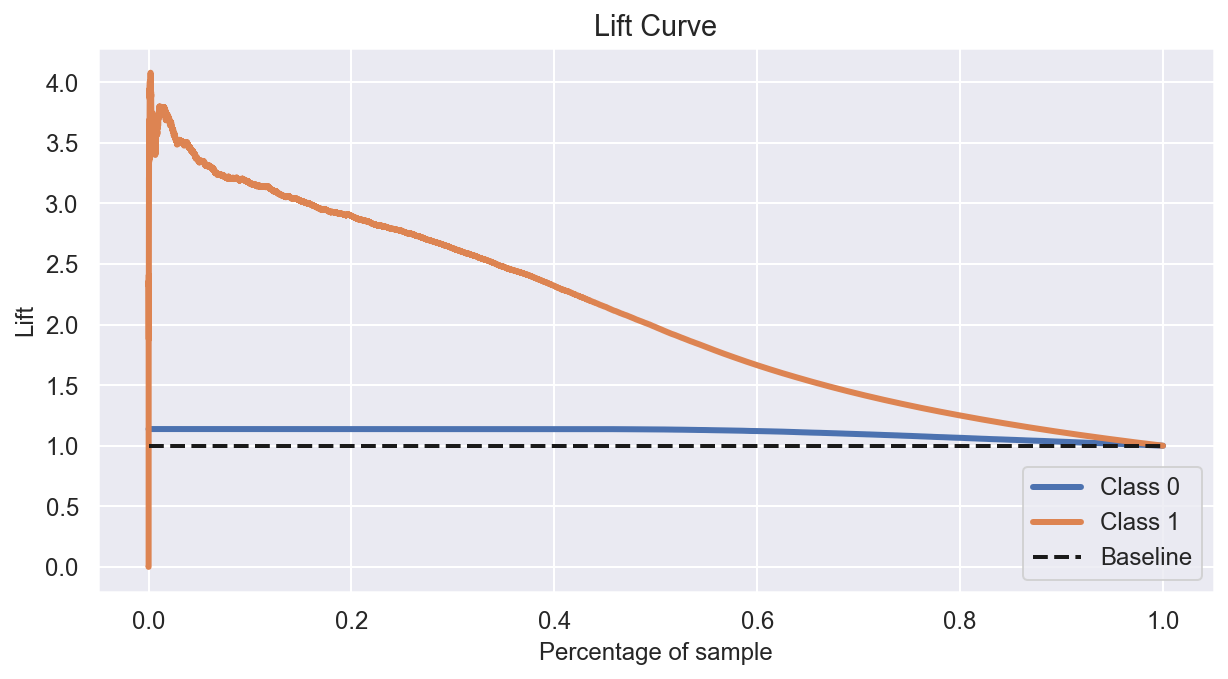

In [278]:
skplt.metrics.plot_lift_curve( y_val, yhat_lgb );

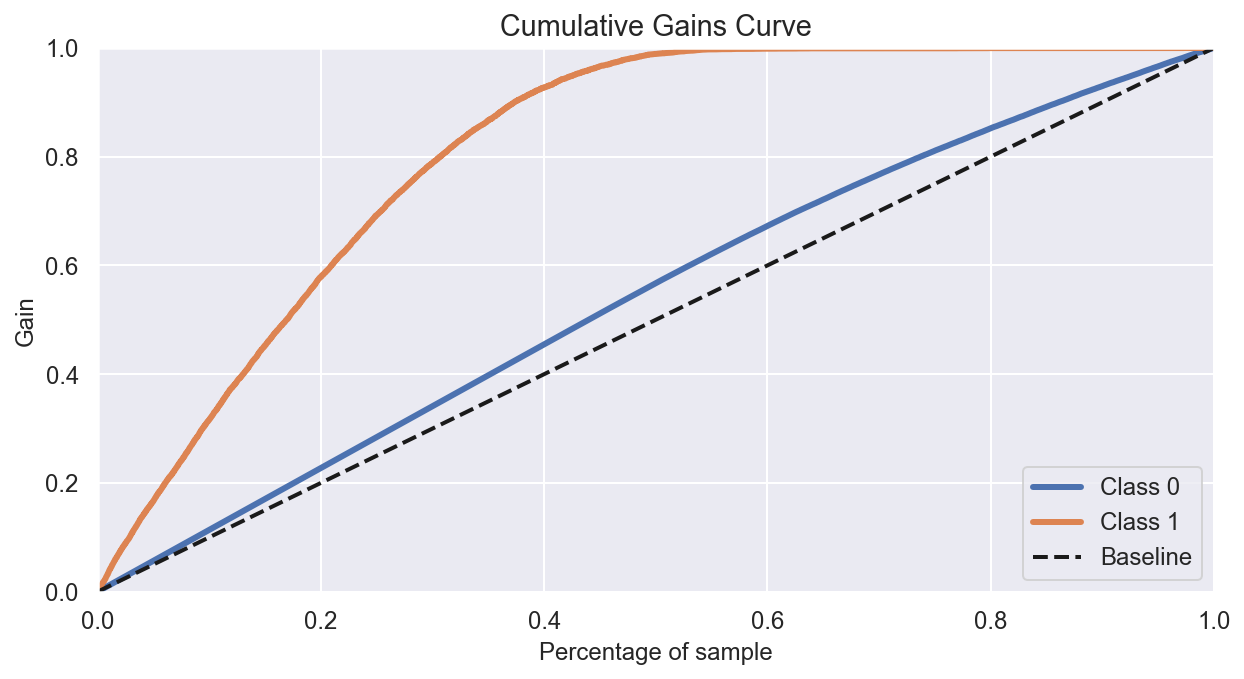

In [279]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgb );

### Stratified Cross Validation

In [280]:
model_lgb_cv = cross_validation( 'LightGBM', model_lgb, x_train, y_train )
model_lgb_cv

,Precision_at_k,Recall_at_k
LightGBM,0.31 +/- 0.0,0.83 +/- 0.0


# 8.0. MODELS PERFORMANCE

## 8.1. Precision and Recall At K metrics performance

In [281]:
all_metrics = pd.concat( [knn_metrics, lr_metrics, et_metrics, model_xgb_metrics, model_lgb_metrics] )
all_metrics

,Precision_at_k,Recall_at_k
KNN,0.295,0.64
Logistic Regression,0.286,0.62
Extra Trees,0.299,0.649
XGBoost,0.329,0.714
LightGBM,0.331,0.719


## 8.2. Cross Validation performance

In [282]:
all_cv = pd.concat( [ knn_cv, lr_cv, et_cv, model_xgb_cv, model_lgb_cv ] )
all_cv

,Precision_at_k,Recall_at_k
KNN,0.28 +/- 0.0,0.76 +/- 0.0
Logistic Regression,0.28 +/- 0.0,0.74 +/- 0.01
Extra Trees,0.29 +/- 0.0,0.77 +/- 0.01
XGBoost,0.31 +/- 0.0,0.82 +/- 0.0
LightGBM,0.31 +/- 0.0,0.83 +/- 0.0


# 9.0. HYPERPARAMETER FINE-TUNING

# 10.0. FINAL METRICS UNDERSTANDING

# 11.0. DEPLOY